# Emotion Detection with Accuracy 50%

## Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation

import re
# import nltk
import string
import fasttext
from collections import Counter
from imblearn.over_sampling import SMOTE
from huggingface_hub import hf_hub_download
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from hazm import Normalizer, word_tokenize, stopwords_list, Lemmatizer,WordTokenizer
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Deep Learning
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, Masking
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

# Modelling
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, classification_report,f1_score

In [ ]:
column_names = ['Text', 'Emotion']

train_data = pd.read_csv("train.tsv", delimiter='\t', header=None, names=column_names, quotechar='"')
test_data = pd.read_csv("test.tsv", delimiter='\t', header=None, names=column_names, quotechar='"')
train_data

,Text,Emotion
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",SAD
3,چون همش با دوربین ثبت شده ، ایا میشه اعتراض زد...,OTHER
4,اين وضع ب طرز خنده داري گريه داره ...,SAD
...,...,...
6120,مرحوم پیش بینی آبکی زیاد میکرد مرحوم عجب آ...,SURPRISE
6121,کلا عین اعتقادات و توئیت زدناتون ... !! در ق...,ANGRY
6122,خب وقتی میگی کسی بیاد مارو بگیره یارو ترس میکن...,FEAR
6123,همون هارو مگه آهنگ جدیدای خواننده‌های دهه ...,SURPRISE


In [ ]:
train_data.info

<bound method DataFrame.info of                                                    Text   Emotion
0     خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...       SAD
1        از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم      HATE
2      "کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...       SAD
3     چون همش با دوربین ثبت شده ، ایا میشه اعتراض زد...     OTHER
4                 اين وضع ب طرز خنده داري گريه داره ...       SAD
...                                                 ...       ...
6120  مرحوم پیش بینی آبکی زیاد میکرد     مرحوم عجب آ...  SURPRISE
6121  کلا عین اعتقادات و توئیت زدناتون ... !!   در ق...     ANGRY
6122  خب وقتی میگی کسی بیاد مارو بگیره یارو ترس میکن...      FEAR
6123  همون هارو     مگه آهنگ جدیدای خواننده‌های دهه ...  SURPRISE
6124                            نیم دگیرش چطور حل نیشد      OTHER

[6125 rows x 2 columns]>

In [ ]:
train_data.describe()

,Text,Emotion
count,6125,6125
unique,6081,7
top,وحشتناکه,OTHER
freq,4,1681


In [ ]:
print(train_data.shape)
print(test_data.shape)

(6125, 2)
(1151, 2)


In [ ]:
# Check the balance
train_data.Emotion.value_counts()

Emotion
OTHER       1681
ANGRY        923
SAD          896
FEAR         757
SURPRISE     739
HAPPY        618
HATE         511
Name: count, dtype: int64

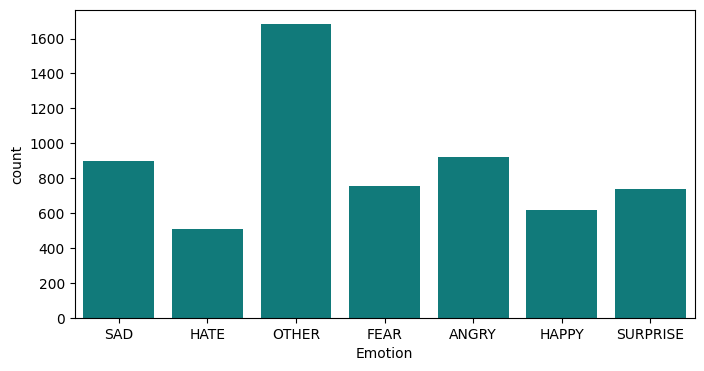

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=train_data, color='darkcyan');

In [ ]:
# NULL values
print(train_data.isnull().sum())
print(train_data.duplicated().sum())

index = train_data[train_data.duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)
print(train_data.shape)

Text       0
Emotion    0
dtype: int64
37
(6088, 2)


In [ ]:
# print the rows which duplicated in the text but with different emotions
train_data[train_data['Text'].duplicated() == True]

,Text,Emotion
2538,#NAME?,HATE
2689,#NAME?,SURPRISE
3251,#NAME?,HAPPY
4735,از دخترای باهوش نمیترسن! برعکس این خودشونن که ...,OTHER
5018,منم واقعا میترسم....هیچوقت فاز کسی که یه بستنی...,SURPRISE
5866,چه جالب,HAPPY
5892,اخ گفتی,SURPRISE


In [ ]:
# Removing duplicated text 
index = train_data[train_data['Text'].duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)

In [ ]:
# Count the number of stopwords in the data
normalizer = Normalizer()
lemmatizer = Lemmatizer()
persian_stopwords = set(stopwords_list())

temp =train_data.copy()
temp['stop_words'] = temp['Text'].apply(
    lambda x: len(set(str(x).split()) & persian_stopwords)
)

print(temp['stop_words'].value_counts())

stop_words
1     743
0     626
2     618
3     522
4     503
5     433
7     366
6     362
8     300
9     281
10    255
11    217
12    200
13    189
14    125
15    105
16     81
17     56
18     44
19     23
20     12
21      6
22      4
24      3
23      3
25      2
87      1
40      1
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

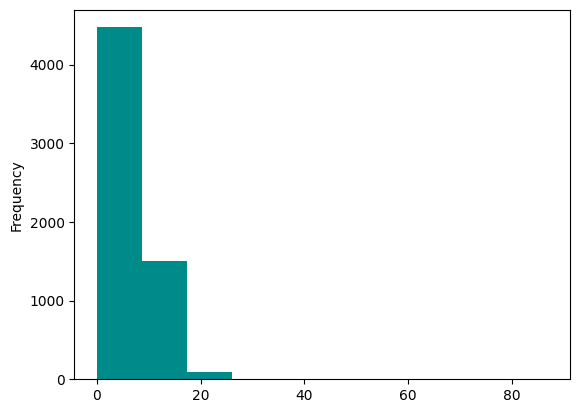

In [ ]:
# Distribution of stopwords
temp['stop_words'].plot(kind= 'hist', color="darkCyan")

In [ ]:
# Check if the data is balanced or not
test_data.Emotion.value_counts()

Emotion
HAPPY       275
SAD         262
OTHER       193
ANGRY       154
SURPRISE    145
HATE         65
FEAR         57
Name: count, dtype: int64

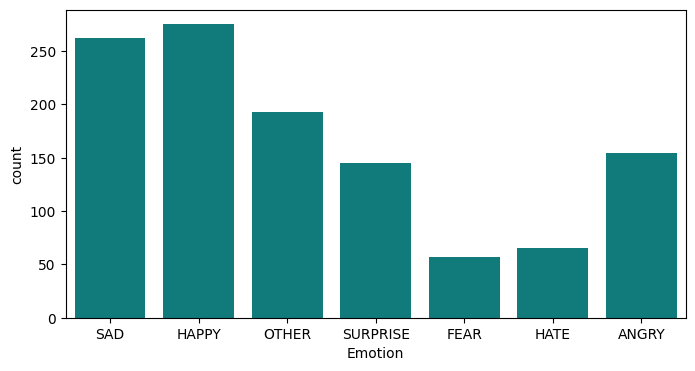

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=test_data, color='darkCyan');

In [ ]:
# Number of null values in each column
print(test_data.isnull().sum())
# Number of duplicated values 
print(test_data.duplicated().sum())

Text       0
Emotion    0
dtype: int64
0


In [ ]:
test_data[test_data['Text'].duplicated() == True]

,Text,Emotion


In [ ]:
temp = test_data.copy()
temp['stop_words'] = temp['Text'].apply(
    lambda x: len(set(str(x).split()) & persian_stopwords)
)

print(temp['stop_words'].value_counts())

stop_words
7     99
6     97
5     93
4     84
3     84
2     83
9     79
10    71
11    70
8     69
12    53
14    47
1     46
15    44
13    35
16    26
0     21
17    20
18    12
19     7
20     5
21     4
22     2
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

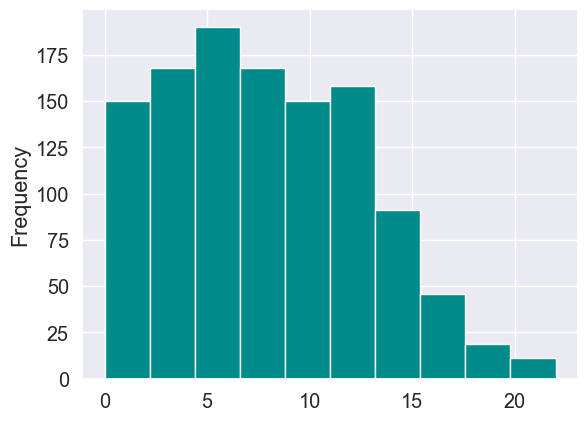

In [ ]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist', color="darkCyan")

In [ ]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    
    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    
    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
        
    return diff_df

In [ ]:
dataframe_difference(train_data, test_data, which='both')

,Text,Emotion,_merge
679,19628b15دوستان تو قسمت دوست به دوست کد من رو و...,OTHER,both
3423,در فلزی بسته به بدنه استوانه ای چسب نواری زده ...,SAD,both
3845,روحش شاد و یادش گرامی باد,SAD,both
5171,من دقیقا از سایت ایکیا چند روز پیش همین کار رو...,SURPRISE,both


## Cleaning

In [ ]:
normalizer = Normalizer()
lemmatizer = Lemmatizer()
persian_stopwords = set(stopwords_list())

def remove_stop_words(text):
    words = [i for i in str(text).split() if i not in persian_stopwords]
    return " ".join(words)

def remove_numbers(text):
    return ''.join([i for i in text if not i.isdigit()])

def to_lower_case(text):
    return " ".join([word.lower() for word in str(text).split()])

def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛', '')
    text = re.sub('\s+', ' ', text)
    return text.strip()

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def hazm_preprocess(text):
    text = normalizer.decrease_repeated_chars(text)
    text = normalizer.persian_number(text)
    text = normalizer.remove_diacritics(text)
    text = normalizer.correct_spacing(text)
    text = normalizer.normalize(text)
    return text

def hazm_lemmatize(text):
    return lemmatizer.lemmatize(text)

def normalized_sentence(sentence):
    sentence = str(sentence)
    sentence = to_lower_case(sentence)
    sentence = hazm_preprocess(sentence)
    sentence = remove_urls(sentence)
    sentence = remove_punctuations(sentence)
    sentence = remove_numbers(sentence)
    sentence = remove_stop_words(sentence)
    sentence = hazm_lemmatize(sentence)
    return sentence

def normalize_text(df):
    df['Text'] = df['Text'].astype(str)
    df['Text'] = df['Text'].apply(to_lower_case)
    df['Text'] = df['Text'].apply(hazm_preprocess)
    df['Text'] = df['Text'].apply(remove_urls)
    df['Text'] = df['Text'].apply(remove_punctuations)
    df['Text'] = df['Text'].apply(remove_numbers)
    df['Text'] = df['Text'].apply(remove_stop_words)
    df['Text'] = df['Text'].apply(hazm_lemmatize)

    return df

def remove_small_sentences(df):
    df['Text'] = df['Text'].apply(lambda x: np.nan if len(str(x).split()) < 3 else x)

In [ ]:
train_data= normalize_text(train_data)
test_data= normalize_text(test_data)

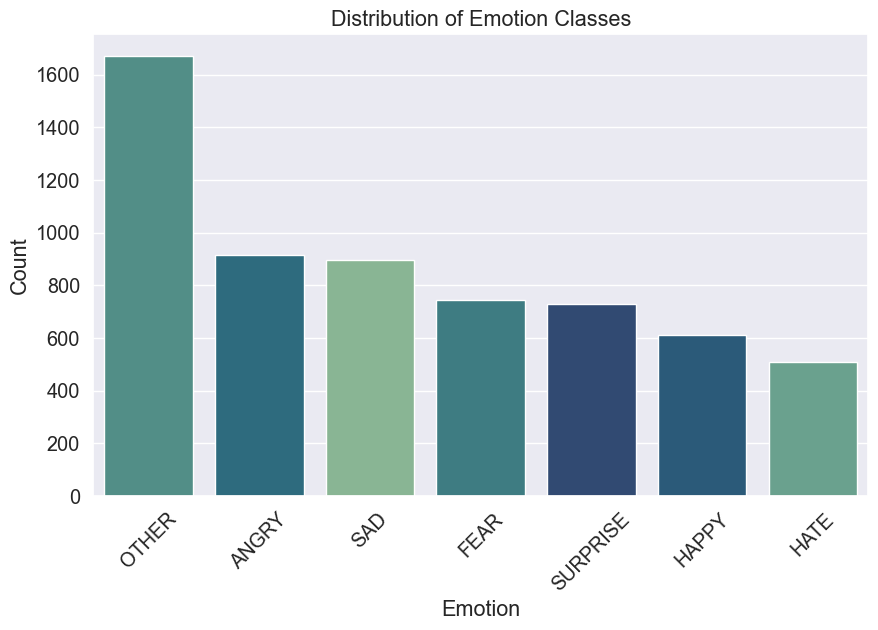

In [ ]:
df = train_data 

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Emotion', hue='Emotion', order=df['Emotion'].value_counts().index, palette='crest',legend=False)
plt.title('Distribution of Emotion Classes')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
normalizer = Normalizer()
tokenizer = WordTokenizer()

def preprocess(text):
    text = normalizer.normalize(str(text))
    tokens = tokenizer.tokenize(text)
    return tokens

df['tokens'] = df['Text'].apply(preprocess)


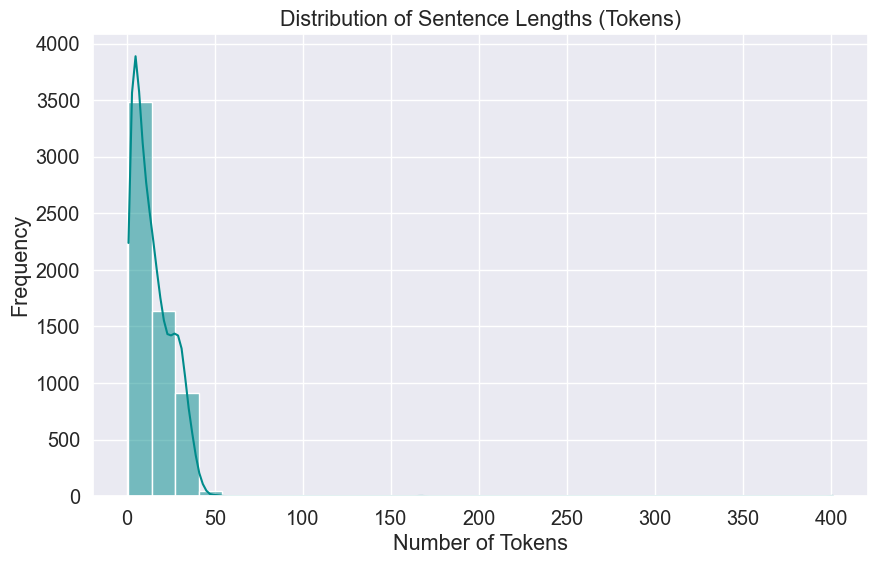

In [ ]:
df['text_length'] = df['tokens'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(df['text_length'], bins=30, kde=True, color='darkCyan')
plt.title('Distribution of Sentence Lengths (Tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()


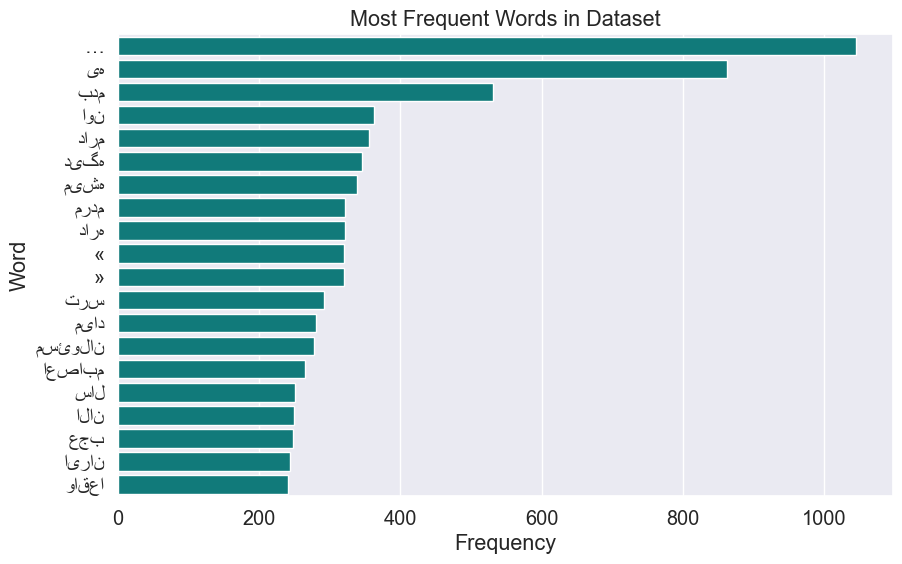

In [ ]:
all_tokens = [token for tokens in df['tokens'] for token in tokens]
most_common = Counter(all_tokens).most_common(20)

words, freqs = zip(*most_common)
plt.figure(figsize=(10,6))
sns.barplot(x=list(freqs), y=list(words), color='darkCyan',legend=False)
plt.title('Most Frequent Words in Dataset')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


## Modeling

In [ ]:
X_train = train_data['Text'].values
y_train = train_data['Emotion'].values

X_test = test_data['Text'].values
y_test = test_data['Emotion'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [ ]:
# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [ ]:
# Vectorize training data first
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_tfidf, y_train_encoded)

In [ ]:
def train_model(model, data, targets):
    """
    Train a model on the given data and targets.
    
    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.
    
    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    text_clf = Pipeline([
        ('clf', model)
    ])
    text_clf.fit(data, targets)
    return text_clf

In [ ]:
def get_F1(true,pred):
    """
    Get the F1 score for the given model on the given data and targets.
    
    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.
    
    Returns:
    array: The F1 score for each class.
    """
    # Calculate the F1 score for the predictions
    return f1_score(true, pred, average='weighted')

In [ ]:
log_reg = train_model(
    LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=0),
    X_train_resampled,
    y_train_resampled
)

X_test_tfidf = tfidf.transform(X_test)

In [ ]:
y_pred_lr = log_reg.predict(X_test_tfidf)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test_encoded, y_pred_lr)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_lr = get_F1(y_test_encoded, y_pred_lr)
pd.DataFrame(f1_lr, index=le.classes_, columns=['F1 score'])

Accuracy:  0.4474370112945265 



,F1 score
ANGRY,0.440464
FEAR,0.440464
HAPPY,0.440464
HATE,0.440464
OTHER,0.440464
SAD,0.440464
SURPRISE,0.440464


In [ ]:
print(classification_report(y_test_encoded, y_pred_lr, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.45      0.31      0.36       154
        FEAR       0.62      0.67      0.64        57
       HAPPY       0.59      0.37      0.45       275
        HATE       0.22      0.11      0.14        65
       OTHER       0.30      0.66      0.41       193
         SAD       0.53      0.60      0.56       262
    SURPRISE       0.59      0.27      0.37       145

    accuracy                           0.45      1151
   macro avg       0.47      0.42      0.42      1151
weighted avg       0.49      0.45      0.44      1151



In [ ]:
X_train_tfidf_orig = tfidf.transform(X_train)

DT = train_model(DecisionTreeClassifier(random_state=0), X_train_tfidf_orig, y_train_encoded)
y_pred_dt = DT.predict(X_test_tfidf)

DT_accuracy =accuracy_score(y_test_encoded, y_pred_dt)
print('Accuracy: ', DT_accuracy,'\n')

f1_dt = get_F1(y_test_encoded, y_pred_dt)
pd.DataFrame(f1_dt, index=le.classes_, columns=['F1 score'])

Accuracy:  0.3631624674196351 



,F1 score
ANGRY,0.356005
FEAR,0.356005
HAPPY,0.356005
HATE,0.356005
OTHER,0.356005
SAD,0.356005
SURPRISE,0.356005


In [ ]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_dt, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.35      0.31      0.33       154
        FEAR       0.50      0.63      0.56        57
       HAPPY       0.48      0.21      0.30       275
        HATE       0.26      0.17      0.21        65
       OTHER       0.26      0.59      0.36       193
         SAD       0.43      0.43      0.43       262
    SURPRISE       0.51      0.27      0.35       145

    accuracy                           0.36      1151
   macro avg       0.40      0.37      0.36      1151
weighted avg       0.41      0.36      0.36      1151



In [ ]:
SVM = train_model(SVC(C=1.0, kernel='linear', probability=True,class_weight='balanced'), X_train_tfidf, y_train_encoded)

y_pred_svm = SVM.predict(X_test_tfidf)

SVM_accuracy = accuracy_score(y_test_encoded, y_pred_svm)
print('Accuracy: ', SVM_accuracy,'\n')

f1_Score = get_F1(y_test_encoded, y_pred_svm)
pd.DataFrame(f1_Score, index=le.classes_, columns=['F1 score'])

Accuracy:  0.45004344048653344 



,F1 score
ANGRY,0.444468
FEAR,0.444468
HAPPY,0.444468
HATE,0.444468
OTHER,0.444468
SAD,0.444468
SURPRISE,0.444468


In [ ]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_svm, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.48      0.39      0.43       154
        FEAR       0.69      0.61      0.65        57
       HAPPY       0.62      0.39      0.48       275
        HATE       0.19      0.09      0.12        65
       OTHER       0.30      0.65      0.41       193
         SAD       0.50      0.58      0.54       262
    SURPRISE       0.60      0.23      0.34       145

    accuracy                           0.45      1151
   macro avg       0.48      0.42      0.42      1151
weighted avg       0.50      0.45      0.44      1151



In [ ]:
RF =train_model(RandomForestClassifier(n_estimators=200, max_depth=50, class_weight='balanced'), X_train_tfidf, y_train_encoded)

y_pred_rf = RF.predict(X_test_tfidf)

RF_accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print('Accuracy: ', RF_accuracy,'\n')

f1_Score = get_F1(y_test_encoded, y_pred_rf)
pd.DataFrame(f1_Score, index=le.classes_, columns=['F1 score']) 

Accuracy:  0.38835794960903564 



,F1 score
ANGRY,0.381462
FEAR,0.381462
HAPPY,0.381462
HATE,0.381462
OTHER,0.381462
SAD,0.381462
SURPRISE,0.381462


In [ ]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_rf, target_names=le.classes_))

In [ ]:
import xgboost as xgb
# =(RandomForestClassifier(n_estimators=200, max_depth=50, class_weight='balanced'), X_train_tfidf, y_train_encoded)

XGB = train_model(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0),X_train_resampled, y_train_resampled)
# xgb_clf.fit()
y_pred_XGB = XGB.predict(X_test_tfidf)
XGB_accuracy = accuracy_score(y_test_encoded, y_pred_XGB)
print('Accuracy: ', XGB_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(y_test_encoded, y_pred_XGB)
pd.DataFrame(f1_Score, index=le.classes_, columns=['F1 score']) 

NameError: name 'train_model' is not defined

In [ ]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_XGB, target_names=le.classes_))

In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        round(log_reg_accuracy, 2),
        round(DT_accuracy, 2),
        round(SVM_accuracy, 2),
        round(RF_accuracy, 2),
        round(XGB_accuracy, 2)
    ],    'F1 Score (Weighted)': [
        round(get_F1(y_test_encoded, y_pred_lr), 2),
        round(get_F1(y_test_encoded, y_pred_dt), 2),
        round(get_F1(y_test_encoded, y_pred_svm), 2),
        round(get_F1(y_test_encoded, y_pred_rf), 2),
        round(get_F1(y_test_encoded, y_pred_XGB), 2)
    ]
})
models_sorted = models.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
models_sorted


In [ ]:
best_model_name = models_sorted.loc[0, 'Model'] 
print("Best model is:", best_model_name)

## LIME

In [ ]:
idx  = 1
Result_pipeline = make_pipeline(tfidf, XGB.named_steps['clf']) 
pred_label = le.inverse_transform(Result_pipeline.predict([X_test[idx]]))[0]
actual_label = y_test[idx] 

explainer = LimeTextExplainer(class_names=le.classes_)
print("Actual Text : ", X_test[idx])
print("Prediction : ", pred_label)     
print("Actual     : ", actual_label)

exp = explainer.explain_instance(X_test[idx], Result_pipeline.predict_proba, top_labels=5)
exp.show_in_notebook()

## New Modeling

In [ ]:
X_train = train_data['Text']
y_train = train_data['Emotion']

X_test = test_data['Text']
y_test = test_data['Emotion']

X_train

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)
print(set(y_train))

In [ ]:
weights = compute_class_weight(class_weight='balanced',
                               classes=np.unique(y_train),
                               y=y_train)

class_weights = dict(enumerate(weights))

sample_weights = np.array([class_weights[i] for i in y_train])

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

## Tokenizing

In [ ]:
def normalize_persian(text):
    text = re.sub("ي", "ی", text)
    text = re.sub("ك", "ک", text)
    text = re.sub("[ًٌٍَُِّْٰ]", "", text)
    return text.lower()

normalized_text = pd.concat([X_train, X_test], axis=0).apply(normalize_persian)
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(normalized_text)

tokenizer.document_count

In [ ]:
tokenizer.texts_to_sequences([X_train.iloc[0]])
tokenizer.texts_to_matrix(X_train[0].split())
tokenizer.texts_to_matrix(X_train[0].split()).shape

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

## Padding

In [ ]:
test_data.shape

In [ ]:
maxlen = max([len(t) for t in train_data['Text']])
maxlen

In [ ]:
maxlen = max(len(seq) for seq in sequences_train)

X_train = pad_sequences(sequences_train, maxlen=maxlen, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlen, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=maxlen, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

In [ ]:
#before
sequences_train[0]

In [ ]:
#after
X_train[0]

## Word Embedding

In [ ]:
model_path = hf_hub_download(
    repo_id="taesiri/PersianWordVecs",
    filename="farsi-dedup-cbow.bin"
)
fasttext_model = fasttext.load_model(model_path)

In [ ]:
embedding_dim = 100  
vocabSize = len(tokenizer.word_index) + 1  

embedding_matrix = np.zeros((vocabSize, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocabSize:
        continue
    embedding_matrix[i] = fasttext_model.get_word_vector(word)

print(f"Embedding matrix shape: {embedding_matrix.shape}")

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
num_tokens = vocabSize
hits=0
misses=0
for word, i in tokenizer.word_index.items():
    if i >= num_tokens:
        continue
    try:
        embedding_vector = fasttext_model.get_word_vector(word)
        embedding_matrix[i] = embedding_vector
        hits += 1
    except:
        misses += 1

print(f"Converted {hits} words ({misses} misses) into embedding vectors.")

In [ ]:
max_len = 100  

model = Sequential()
model.add(
    Embedding(
        input_dim=vocabSize,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False 
    )
)
model.add(Masking(mask_value=0.0))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax', kernel_regularizer=l2(0.01)))

adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', f1_m])

model.summary()

In [ ]:
model.build(input_shape=(None, 100))
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
# Fit model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,  
    callbacks=[callback],
    verbose=1
)

In [ ]:
#Overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1) 

In [ ]:
#Overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1) 

In [ ]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(test_data['Emotion']), y_pred))

In [ ]:
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
# Classify custom sample
sentences = [
             "با اینکار خوشحال شدم",
            "اه تف به این زندگی",
            ]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")